In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import sqlalchemy as sa
import RunData.MyaData as Mya
from RGA import *
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default="plotly_white"
pio.renderers.default = 'jupyterlab'  # Alternate: 'browser' opens new browser window with plots.

Imported the RGA info. Setting up data.
setup_rundata_structures(data,(datetime(), datetime()))


## Select the run period
Set the selected_run_period for RGA from 0, 1 or 2.

In [2]:
run_sub_periods_available = [
        (datetime(2018, 2,  5, 20, 0), datetime(2018,  2,  8, 6, 0)),
        (datetime(2018, 9, 27,  1, 0), datetime(2018, 11, 26, 7, 0)),
        (datetime(2019, 3, 25, 18, 0), datetime(2019,  4, 15, 6, 0))
    ]
data.debug = 1
# Select the run period you want to inspect from 0 to 2.
selected_run_period = 2
print(f"Selected data from run period {selected_run_period} from "
      f"{run_sub_periods_available[selected_run_period][0]:%Y-%m-%d} to {run_sub_periods_available[selected_run_period][1]:%Y-%m-%d}")

Selected data from run period 2 from 2019-03-25 to 2019-04-15


In [3]:
setup_rundata_structures(data, run_sub_periods_available[selected_run_period])

Fetching the data from 2019-03-25 18:00:00 to 2019-04-15 06:00:00
get_runs from 2019-03-25 18:00:00 - 2019-04-15 06:00:00 
Getting data from cache for 2019-03-25 18:00:00 - 2019-04-15 06:00:00 > 500000 evt. 


## Select the run number
For inspecting the run parameters below, choose a run number from the available runs.
You can either select the `i_run`, which is the nth +1 run in the data set and keep `run_number = None`, or you can set `run_number` which is the actual number of the run, but make sure this run_number is actually in the data set.

In [4]:
print("Runs available in this time span:")
print(f"i_run = {0:4d}  --> {data.All_Runs.iloc[0].name}")
print(f"i_run = {len(data.All_Runs)-1:4d}  --> {data.All_Runs.iloc[-1].name}")

Runs available in this time span:
i_run =    0  --> 6608
i_run =  153  --> 6782


In [5]:
# Select the run you want to inspect.
run_number = None
i_run = 12
if run_number is None:
    start_time = data.All_Runs.iloc[i_run].start_time
    end_time = data.All_Runs.iloc[i_run].end_time
    run_number = data.All_Runs.iloc[i_run].name
else:
    i_run = data.All_Runs.index.get_loc(run_number)
    start_time = data.All_Runs.loc[run_number].start_time
    end_time = data.All_Runs.loc[run_number].end_time
           
print(f"Run number = {run_number} index no = {i_run} start_time = {start_time}  end_time = {end_time}")

Run number = 6630 index no = 12 start_time = 2019-03-27 09:56:31  end_time = 2019-03-27 10:01:21


In [6]:
# Initialize the data for the FCUP. We get the entire period because otherwise the beam_stop_atten may be empty.
beam_stop_atten_time, fcup_offset_time =  \
    initialize_fcup_param(run_sub_periods_available[0][0], run_sub_periods_available[2][1])
# Quickly check the sort of this data, since this was an issue before.
fc_sort = fcup_offset_time.index.sort_values()
if np.any((fc_sort == fcup_offset_time.index) == False):
    print("The fcup_offset_time data set is not properly sorted!")

Getting beam_stop_atten.
Getting fcup_offset.


In [7]:
# Uncomment to inspect the FCup data in a table format.
#print("Beam Stop Atten:")
#for inx,item in beam_stop_atten_time.iterrows():
#    print(f"{inx:%Y-%m-%d %H:%M:%S}, {item.value:8.5f}")
#print("FCup Offset")
#for inx,item in fcup_offset_time.iloc[10:16].iterrows():
#    print(f"{inx:%Y-%m-%d %H:%M:%S}, {item.value:8.5f}")

In [8]:
livetime = data.Mya.get(channel="B_DAQ:livetime", start=start_time, end=end_time, run_number=run_number)
livetime_pulser = data.Mya.get(channel="B_DAQ:livetime_pulser", start=start_time, end=end_time, run_number=run_number)
if len(livetime_pulser)>2:
    livetime_pulser.drop(['t','x'], inplace=True, axis=1)
ipm2c21a = data.Mya.get(channel="IPM2C21A", start=start_time, end=end_time, run_number=run_number)
ipm2c24a = data.Mya.get(channel="IPM2C24A", start=start_time, end=end_time, run_number=run_number)
fcup_current = compute_fcup_current(run_number, data=data, current_channel="scalerS2b")

run 6630 - No data received for channel: B_DAQ:livetime between 2019-03-27 09:56:31 and 2019-03-27 10:01:21.


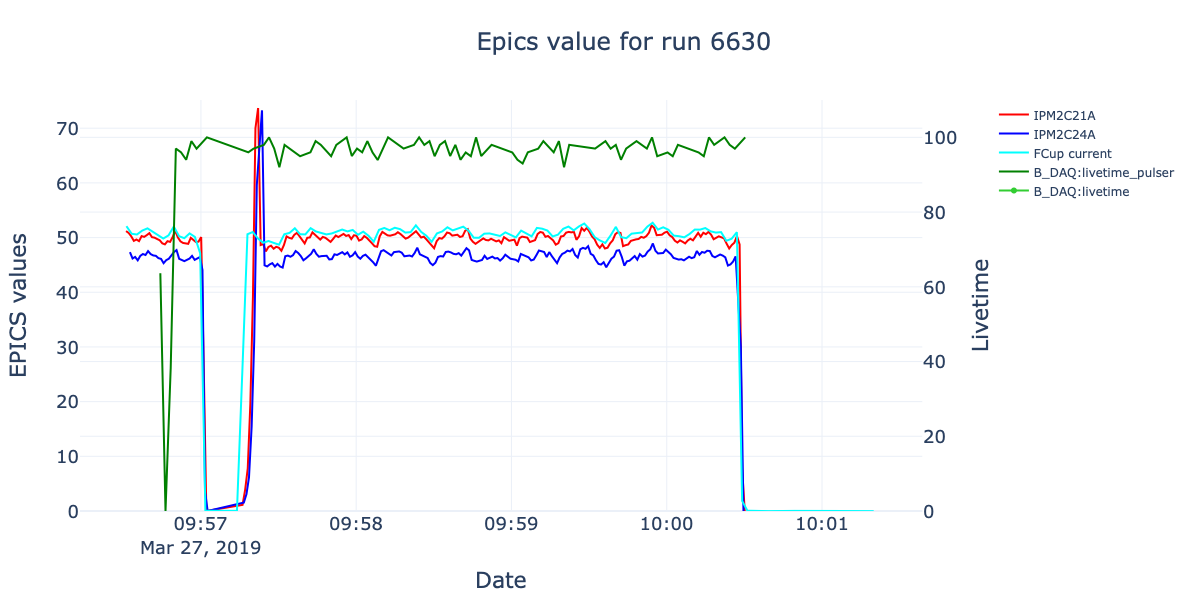

In [9]:
max_y_epics = np.max( [ipm2c21a["value"].max(), ipm2c24a["value"].max()])
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.update_layout(height=600, width=1200, 
                  title=go.layout.Title(text=f"Epics value for run {data.All_Runs.iloc[i_run].name}", xanchor="left", x=0.4),
                  titlefont=dict(size=24),)
fig.add_trace(go.Scatter(x=ipm2c21a["time"], y=ipm2c21a["value"], name="IPM2C21A", line=dict(color="red")))
fig.add_trace(go.Scatter(x=ipm2c24a["time"], y=ipm2c24a["value"], name="IPM2C24A", line=dict(color="blue")))
fig.add_trace(go.Scatter(x=fcup_current["time"], y=fcup_current["value"], name="FCup current", line=dict(color="aqua")))
fig.add_trace(go.Scatter(x=livetime_pulser["time"], y=livetime_pulser["value"], name="B_DAQ:livetime_pulser", line=dict(color="green")), 
               secondary_y=True)
fig.add_trace(go.Scatter(x=livetime["time"], y=livetime["value"], name="B_DAQ:livetime", line=dict(color="limegreen")), 
               secondary_y=True)
fig.update_xaxes(title_text="Date", titlefont=dict(size=22), tickfont=dict(size=18))
fig.update_yaxes(title_text="EPICS values", titlefont=dict(size=22),range=[0., max_y_epics*1.02], tickfont=dict(size=18))
fig.update_yaxes(title_text="Livetime", titlefont=dict(size=22),range=[0., 110.], tickfont=dict(size=18), secondary_y=True)
fig.show()

## FCup Calculation Values
Inspect the values that go into the FCup current calculation. 

In [10]:
bsat = beam_stop_atten_time.index.get_indexer([start_time], method='nearest')
beam_stop_atten = beam_stop_atten_time.iloc[bsat]

scalerS2b = data.Mya.get(channel="scalerS2b", start=start_time, end=end_time, run_number=run_number)

fcup_offset = fcup_offset_time.loc[start_time:end_time]    # Get the FCup offset values.
fcup_prepend = fcup_offset_time.iloc[fcup_offset_time.index.get_indexer([start_time], method='ffill')] # Get one more before the start_time
fcup_prepend.index=[scalerS2b.iloc[0].time]                                                            # Reset the index of last fcup value to start_time
fcup_offset = pd.concat([fcup_prepend,fcup_offset])                                                    # Add the one value to the list.

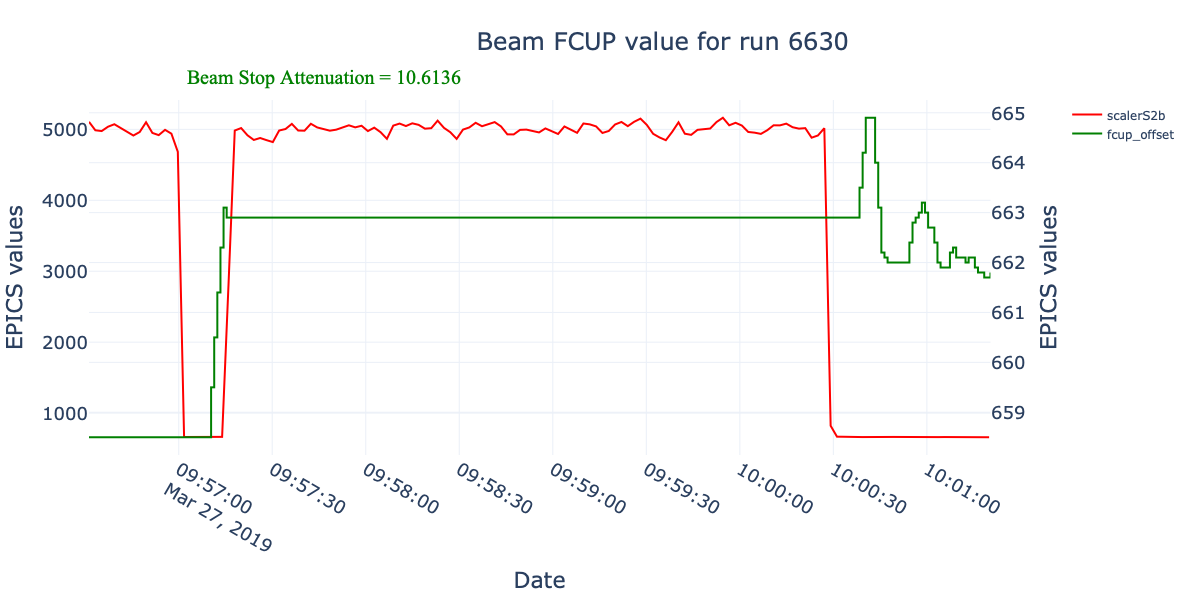

In [26]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.update_layout(height=600, width=1200, 
                  title=go.layout.Title(text=f"Beam FCUP value for run {data.All_Runs.iloc[i_run].name}", xanchor="left", x=0.4),
                  titlefont=dict(size=24),)
fig.add_trace(go.Scatter(x=scalerS2b["time"], y=scalerS2b["value"], name="scalerS2b", line=dict(color="red")))
fig.add_trace(go.Scatter(x=fcup_offset.index, y=fcup_offset["value"], name="fcup_offset", line=dict(color="green"), line_shape='hv'), 
              secondary_y=True)
#fig.add_trace(go.Scatter(x=[scalerS2b.iloc[0].time, scalerS2b.iloc[-1].time], 
#                         y=[beam_stop_atten.value.mean(),beam_stop_atten.value.mean()], name="IPM2C24A", line=dict(color="limegreen")),
#                         secondary_y=True)
fig.update_xaxes(title_text="Date", titlefont=dict(size=22), tickfont=dict(size=18))
fig.update_yaxes(title_text="EPICS values", titlefont=dict(size=22), tickfont=dict(size=18))
#fig.update_yaxes(title_text="Livetime", titlefont=dict(size=22),range=[0., 110.], tickfont=dict(size=18), secondary_y=True)
fig.add_annotation(x=0.1, y=1.1, xref='paper', yref='paper', text=f"Beam Stop Attenuation = {float(beam_stop_atten.value)}", showarrow=False,
                  font=dict(family="Times New Roman", size=20, color="green"))
fig.show()